# AI6128 Urban Computing

## Colab Settings

In [1]:
import os, sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = 'maintrain_final.ipynb'
    %cd /content/drive/My Drive/URCOMPU_project1/code
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

## Helper Function to get all Site and Floor names

In [2]:
import os, sys
def get_site_floors(data_dir: str) -> []:
    site_floors = []
    sites = [(f.name, f.path) for f in os.scandir(data_dir) if f.is_dir()]
    for site_name, site_dir in sites:
        site_floors.extend([(site_name, f.name) for f in os.scandir(site_dir) if f.is_dir()])

    return site_floors

site_floors = get_site_floors('./data')
print(site_floors)

[('site1', 'B1'), ('site1', 'F1'), ('site1', 'F2'), ('site1', 'F3'), ('site1', 'F4'), ('site2', 'B1'), ('site2', 'F1'), ('site2', 'F2'), ('site2', 'F3'), ('site2', 'F4'), ('site2', 'F5'), ('site2', 'F6'), ('site2', 'F7'), ('site2', 'F8')]


## Main Model

In [8]:
import numpy as np
import random
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from data import split_floor_data
from sklearn.preprocessing import StandardScaler


random.seed(2)
torch.manual_seed(2)
class FloorData(Dataset):
    def __init__(self, floordata):
        self.features = floordata[:, 2:]
        self.labels = floordata[:, :2]
        self.length = floordata.shape[0]

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return self.length

#------------------------------------------  model

class Encoder(nn.Module):
    def __init__(self, wifi_dim, ibeacon_dim, output_dim=32, hidden_magn=32, hidden_wifi=64, hidden_ibeacon=64, drop_rate=0.4, actfunc=nn.ReLU, use_wifi=True, use_ibeacon=True):
        super(Encoder, self).__init__()
        self.activate_function = actfunc
        self.wifi_dim = wifi_dim 
        self.ibeacon_dim = ibeacon_dim
        self.feature_dim = 4+hidden_magn+(hidden_ibeacon+1 if use_ibeacon else 0)+(hidden_wifi+1 if use_wifi else 0)
        self.use_wifi = use_wifi
        self.use_ibeacon = use_ibeacon

        self.magn_encoder = nn.Sequential(
            nn.Linear(4, hidden_magn*2),
            nn.BatchNorm1d(hidden_magn*2),
            nn.Dropout(drop_rate*0.25),
            actfunc(),
            nn.Linear(hidden_magn*2, hidden_magn),
            )

        self.wifi_encoder = nn.Sequential(
            nn.Linear(wifi_dim+1, hidden_wifi*4),
            nn.BatchNorm1d(hidden_wifi*4),
            nn.Dropout(drop_rate*0.5),
            actfunc(),
            nn.Linear(hidden_wifi*4, hidden_wifi*2),
            nn.BatchNorm1d(hidden_wifi*2),
            nn.Dropout(drop_rate),
            actfunc(),
            nn.Linear(hidden_wifi*2, hidden_wifi),
            )
        
        self.ibeacon_encoder = nn.Sequential(
            nn.Linear(ibeacon_dim+1, hidden_ibeacon*4),
            nn.BatchNorm1d(hidden_ibeacon*4),
            nn.Dropout(drop_rate*0.5),
            actfunc(),
            nn.Linear(hidden_ibeacon*4, hidden_ibeacon*2),
            nn.BatchNorm1d(hidden_ibeacon*2),
            nn.Dropout(drop_rate),
            actfunc(),
            nn.Linear(hidden_ibeacon*2, hidden_ibeacon),
            )

        self.encoder = nn.Sequential(
            nn.BatchNorm1d(self.feature_dim),
            actfunc(),
            nn.Linear(self.feature_dim, output_dim*4),
            nn.BatchNorm1d(output_dim*4),
            nn.Dropout(drop_rate*0.5),
            actfunc(),
            nn.Linear(output_dim*4, output_dim*2),
            nn.BatchNorm1d(output_dim*2),
            actfunc(), 
            nn.Linear(output_dim*2, output_dim),
            )

    def forward(self, x):
        magn_o, wifi_det, ibeacon_det, wifi_o, ibeacon_o = x.split([4,1,1,self.wifi_dim, self.ibeacon_dim], dim=1)
        
        magn_out = self.magn_encoder(magn_o)

        if self.use_wifi:
            wifi = torch.cat([wifi_det, wifi_o], dim=1)
            wifi_out = self.wifi_encoder(wifi)
        if self.use_ibeacon:
            ibeacon = torch.cat([ibeacon_det, ibeacon_o], dim=1)
            ibeacon_out = self.ibeacon_encoder(ibeacon)

        if self.use_wifi:
            if self.use_ibeacon:
                output = torch.cat([magn_o, magn_out, wifi_out, ibeacon_out, wifi_det, ibeacon_det], dim=1)
            else:
                output = torch.cat([magn_o, magn_out, wifi_out, wifi_det], dim=1)
        else:
            if self.use_ibeacon:
                output = torch.cat([magn_o, magn_out, ibeacon_out, ibeacon_det], dim=1)
            else:
                output = torch.cat([magn_o, magn_out], dim=1)

        output = self.encoder(output)

        return output


class Decoder(nn.Module):
    def __init__(self, input_dim=32, hidden=64, drop_rate=0.2, actfunc=nn.Tanh):
        super(Decoder, self).__init__()
        self.activate_function = actfunc

        self.decoder = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.Dropout(drop_rate),
            actfunc(),
            nn.Linear(hidden, hidden*2),
            nn.BatchNorm1d(hidden*2),
            nn.Dropout(drop_rate),
            actfunc(),
            nn.Linear(hidden*2, 2),
            )

    def forward(self, x):
        return self.decoder(x)


class DLnetwork(nn.Module):
    def __init__(self, wifi_dim, ibeacon_dim, augmentation=True, use_wifi=True, use_ibeacon=True):
        super(DLnetwork, self).__init__()
        if not augmentation: # for ground truth data
            self.encoder = Encoder(wifi_dim, ibeacon_dim, output_dim=32, hidden_magn=32, 
                                   hidden_wifi=32, hidden_ibeacon=32, drop_rate=0, actfunc=nn.ReLU,
                                   use_wifi=use_wifi, use_ibeacon=use_ibeacon)
            self.decoder = Decoder(input_dim=32, hidden=64, drop_rate=0, actfunc=nn.ReLU)
        else: # for augmented data
            self.encoder = Encoder(wifi_dim, ibeacon_dim, output_dim=32, hidden_magn=32, 
                                   hidden_wifi=128, hidden_ibeacon=128, drop_rate=0, actfunc=nn.ReLU,
                                   use_wifi=use_wifi, use_ibeacon=use_ibeacon)
            self.decoder = Decoder(input_dim=32, hidden=64, drop_rate=0, actfunc=nn.ReLU)

    def forward(self, x):
        return self.decoder(self.encoder(x))

#---------------------------------------------------------------------

class DLModel:
    def __init__(self, site, floor, batchsize=64, testratio=0.1, device='cuda', use_augmentation=True, use_wifi=True, use_ibeacon=True):
        self.site, self.floor = site, floor
        self.batchsize = batchsize
        self.testratio = testratio
        self.use_augmentation = use_augmentation
        self.trained_epochs = 0
        self.loss_error = [[],[],[]] # trainloss, trainerror, testerror
        self.trainDataLoader, self.testDataLoader = None, None
        self.y_mean, self.y_std = None, None
        self.lr = None
        self.model = None
        self.bssid2index = None
        self.uuid2index = None 
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.use_wifi=use_wifi
        self.use_ibeacon=use_ibeacon
        self.scaler=None

    def initial(self):
        self.load_data()
        self.initial_model(len(self.bssid2index), len(self.uuid2index))

    def load_data(self): # create a dataloader for train and test
        print('Loading and preprocessing data from txt...')
        train_set, test_set, (self.bssid2index, self.uuid2index) = split_floor_data(self.site, self.floor, self.testratio, augmentation=self.use_augmentation)
        scaler = StandardScaler()
        self.scaler=scaler
        train_set[:,2:6] = scaler.fit_transform(train_set[:,2:6].copy())
        test_set[:,2:6] = scaler.transform(test_set[:,2:6].copy())
        y = train_set[:, :2]
        self.y_mean, self.y_std = torch.Tensor(y.mean(axis=0)).to(self.device), torch.Tensor(y.std(axis=0)).to(self.device)
        self.trainDataLoader = DataLoader(FloorData(train_set), batch_size=self.batchsize, shuffle=True)
        self.testDataLoader = DataLoader(FloorData(test_set), batch_size=self.batchsize, shuffle=False)
        print('data loading finish')

    def initial_model(self, wifi_dim, ibeacon_dim):
        self.model = DLnetwork(wifi_dim, ibeacon_dim, augmentation=self.use_augmentation, 
            use_wifi=self.use_wifi, use_ibeacon=self.use_ibeacon).to(self.device)
        print('model initialization finish')

    def train(self, epochs, reduce_lr_epoch=5, startlr=0.1, verbose=True):
        if startlr is None:
            if self.lr is None:
                cur_lr = 0.01
            else:
                cur_lr = self.lr 
        else:
            cur_lr = startlr
            self.lr = cur_lr
        optimizer = torch.optim.Adam(self.model.parameters(), lr=cur_lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, 
                                                               patience=reduce_lr_epoch, cooldown=5, min_lr=1e-5)
        criterion = nn.MSELoss()
        self.model.train()
        for epoch in range(1, epochs+1):
            epoch_loss = 0
            epoch_error = 0
            batch_number = 0

            for x, y in iter(self.trainDataLoader):
                batch_number += 1 
                x = x.float().to(self.device)
                y = y.float().to(self.device)
                pred = self.model(x)
                error = torch.sum(torch.sqrt(torch.sum((y-(pred*self.y_std + self.y_mean))**2, dim=1))) / y.shape[0]
                epoch_error += error.detach().item()

                loss = criterion(pred, (y-self.y_mean)/self.y_std)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.detach().item()

            mean_loss = epoch_loss / batch_number
            mean_error = epoch_error / batch_number
            test_error = self.evaluate()
            self.trained_epochs += 1
            self.loss_error[0].append(mean_loss)
            self.loss_error[1].append(mean_error)
            self.loss_error[2].append(test_error.detach().item())
            if verbose:
              print(f'epoch: {self.trained_epochs} | lr: {optimizer.param_groups[0]["lr"]} |epoch loss: {mean_loss} | \
                  Euclidean distance error on epoch: {mean_error}| Euclidean distance error on TestSet: {test_error} ')   
            #scheduler.step(mean_loss)
            scheduler.step(test_error.detach())
            
            if epoch > 100 and all(past_error <= test_error.detach().item() for past_error in list(self.loss_error[2])[-20:]):
              print(f'Early stopping at Epoch {epoch}')
              break

        return np.min(self.loss_error[2]), np.argmin(self.loss_error[2])+1



    def evaluate(self):
        self.model.eval()
        total_error = 0
        batch_number = 0
        with torch.no_grad():
            for x, y in iter(self.testDataLoader):
                batch_number += 1 
                x = x.float().to(self.device)
                y = y.float().to(self.device)
                pred = self.model(x)
                error = torch.sum(torch.sqrt(torch.sum((y-(pred*self.y_std + self.y_mean))**2, dim=1))) / y.shape[0]
                total_error += error
        mean_error = total_error / batch_number
        return mean_error


    def plotloss(self):
        epochs = list(range(1, len(self.loss_error[0])+1))
        if not epochs:
            print(f'0 epoch trained')
            return

        plt.clf()
        fig = plt.figure(figsize=(12,8), dpi=80)
        loss_fig = fig.add_subplot(2,1,1)
        error_fig = fig.add_subplot(2,1,2)
        loss_fig.plot(epochs, self.loss_error[0], label='train loss',linestyle='-', color='red')
        error_fig.plot(epochs, self.loss_error[1], label='train error', linestyle='-', color='blue')
        error_fig.plot(epochs, self.loss_error[2], label='test error', linestyle='-', color='green')
        loss_fig.legend(loc='upper right')
        error_fig.legend(loc='upper right')
        plt.savefig('loss.jpg', bbox_inches='tight')
        plt.show()


    def predict(self, data, groundtruth=None):
        # data = {Mx, My, Mz, {bssid:rssi}, {uuid:rssi}}
        self.model.eval()
        x = torch.zeros([1,6+len(self.bssid2index)+len(self.uuid2index)])
        Mx, My, Mz = data[:3]
        MI = (Mx**2 + My**2 + Mz**2)**0.5
        Mx, My, Mz, MI = self.scaler.transform(np.array([[Mx,My,Mz,MI]]))[0]
        wifis = data[3]
        ibeacons = data[4]
        wifi_det, ibeacon_det = 1 if wifis else 0, 1 if ibeacons else 0
        x[0][:6] = torch.Tensor([[Mx, My, Mz, MI, wifi_det, ibeacon_det]])
        for bssid, rssi in wifis.items():
            if bssid in self.bssid2index:
                x[0][6+self.bssid2index[bssid]] = (100+rssi) / 100 
        for uuid, rssi in ibeacons.items():
            if uuid in self.uuid2index:
                x[0][6+len(self.bssid2index)+self.uuid2index[uuid]] = (100+rssi) / 100
        x = x.to(self.device)

        pred = self.model(x)
        pred = pred * self.y_std + self.y_mean
        pred = (float(pred[0][0]), float(pred[0][1]))

        plt.clf()
        plt.figure(figsize=(6,6), dpi=160)
        json_path = os.path.join('./data', self.site, self.floor, 'floor_info.json')
        with open(json_path) as file:
            mapinfo = json.load(file)['map_info']
        mapheight, mapwidth = mapinfo['height'], mapinfo['width']
        img = mpimg.imread(os.path.join('./data', self.site, self.floor, 'floor_image.png'))
        plt.imshow(img)
        mapscaler = (img.shape[0]/mapheight + img.shape[1]/mapwidth)/2
        pre = plt.scatter([pred[0]*mapscaler], [img.shape[0] - pred[1]*mapscaler], color='red', marker='o', s=7)
        if groundtruth:
            real = plt.scatter([groundtruth[0]*mapscaler], [img.shape[0] - groundtruth[1]*mapscaler], color='green', marker='x', s=7)
            plt.legend([pre, real], ['prediction', 'groundtruth'], loc='lower left')
        else:
            plt.legend([pre], ['prediction'], loc='lower left')
        plt.xticks((np.arange(25, mapwidth, 25) * mapscaler).astype('uint'), np.arange(25, mapwidth, 25).astype('uint'))
        plt.yticks((img.shape[0] - np.arange(25, mapheight, 25) * mapscaler).astype('uint'), np.arange(25, mapheight, 25).astype('uint'))
        plt.show()




'''
use_augmentation: Whether use augmented data or GroundTruth data 
use_wifi:     Whether use wifi feature
use_ibeacon:    Whether use ibeacon feature
'''
test_one = True
aug = False
bs = 32 if not aug else 64

if not test_one:
  aug = False
  bs = 32 if not aug else 64
  use_wifi = True
  use_ibeacon = False
  all_models = []
  for site, floor in site_floors:
    model = DLModel(site, floor, batchsize=bs, device='cuda', testratio=0.2, use_augmentation=aug, use_wifi=use_wifi, use_ibeacon=use_ibeacon)
    model.initial()
    all_models.append((site, floor, model))
else:
  model = DLModel('site2', 'F4', batchsize=bs, device='cuda', testratio=0.2, use_augmentation=aug, use_wifi=True, use_ibeacon=False)
  model.initial()

Loading and preprocessing data from txt...
already read 10 txts
already read 20 txts
Total data instance: 215, train number: 172, test number: 43

There are 19 steps that did not find wifi, and 151 steps that did not find ibeacon.
There are 8 bssids and 2 uuids which were detected in testset while not detected in trainset, so that they were discard.
Final wifi bssid number: 1953, ibeacon uuid number: 9
data loading finish
model initialization finish


In [9]:
if test_one:
  min_val_error, stop_epoch = model.train(300, reduce_lr_epoch=15, startlr=0.01)
  print(min_val_error, stop_epoch)
else:
  print(f'=> Training models for BS: {bs}, AUG: {aug}, use_wifi: {use_wifi}, use_ibeacon: {use_ibeacon}')
  results = []
  for site, floor, model in all_models:
    print(f'=> Training {site} -- {floor}')
    min_val_error, stop_epoch = model.train(300, reduce_lr_epoch=15, startlr=0.01, verbose=False)
    results.append([site, floor, min_val_error, stop_epoch])
  print(results)
  avg_err = np.mean([result[2] for result in results])
  print(avg_err)

epoch: 1 | lr: 0.01 |epoch loss: 0.8450387765963873 |                   Euclidean distance error on epoch: 53.276929219563804| Euclidean distance error on TestSet: 53.447059631347656 
epoch: 2 | lr: 0.01 |epoch loss: 0.6281986037890116 |                   Euclidean distance error on epoch: 45.535804748535156| Euclidean distance error on TestSet: 43.553321838378906 
epoch: 3 | lr: 0.01 |epoch loss: 0.36670511960983276 |                   Euclidean distance error on epoch: 35.199524879455566| Euclidean distance error on TestSet: 38.69327163696289 
epoch: 4 | lr: 0.01 |epoch loss: 0.2652054776748021 |                   Euclidean distance error on epoch: 26.981682141621906| Euclidean distance error on TestSet: 30.802108764648438 
epoch: 5 | lr: 0.01 |epoch loss: 0.3797217706839244 |                   Euclidean distance error on epoch: 32.02000363667806| Euclidean distance error on TestSet: 28.083724975585938 
epoch: 6 | lr: 0.01 |epoch loss: 0.2201338211695353 |                   Euclidean

# Results
+ BS: 32, AUG: False, use_wifi: True, use_ibeacon: True \\
[['site2', 'F1', 10.727468490600586, 79], ['site2', 'F2', 11.91236400604248, 66], ['site2', 'F4', 14.514928817749023, 53], ['site2', 'B1', 10.615411758422852, 88], ['site2', 'F3', 15.591279983520508, 59], ['site2', 'F6', 11.866670608520508, 101], ['site2', 'F8', 8.890729904174805, 102], ['site2', 'F5', 6.28755521774292, 93], ['site2', 'F7', 8.070944786071777, 113], ['site1', 'F4', 8.591798782348633, 78], ['site1', 'B1', 10.733821868896484, 54], ['site1', 'F3', 10.396078109741211, 36], ['site1', 'F1', 8.37698745727539, 67], ['site1', 'F2', 9.975752830505371, 57]] \\
10.467985187258039
+ BS: 32, AUG: False, use_wifi: False, use_ibeacon: True \\
[['site2', 'F1', 36.944725036621094, 48], ['site2', 'F2', 42.6666259765625, 67], ['site2', 'F4', 43.560546875, 34], ['site2', 'B1', 28.2203426361084, 50], ['site2', 'F3', 36.45487976074219, 55], ['site2', 'F6', 42.35984802246094, 45], ['site2', 'F8', 35.427581787109375, 20], ['site2', 'F5', 46.88574981689453, 38], ['site2', 'F7', 35.94985580444336, 24], ['site1', 'F4', 40.998634338378906, 30], ['site1', 'B1', 33.333824157714844, 33], ['site1', 'F3', 45.50345230102539, 40], ['site1', 'F1', 50.83878707885742, 35], ['site1', 'F2', 41.768531799316406, 29]]
40.06524181365967
+ Training models for BS: 32, AUG: False, use_wifi: True, use_ibeacon: False
[['site2', 'F1', 11.638440132141113, 104], ['site2', 'F2', 10.85118293762207, 53], ['site2', 'F4', 14.062921524047852, 72], ['site2', 'B1', 10.142155647277832, 60], ['site2', 'F3', 15.458612442016602, 56], ['site2', 'F6', 13.5276460647583, 80], ['site2', 'F8', 6.896326541900635, 59], ['site2', 'F5', 5.945248603820801, 91], ['site2', 'F7', 8.873299598693848, 38], ['site1', 'F4', 9.61227035522461, 46], ['site1', 'B1', 11.535935401916504, 38], ['site1', 'F3', 10.401960372924805, 117], ['site1', 'F1', 9.051582336425781, 67], ['site1', 'F2', 9.048416137695312, 66]]
10.503285578319005
+ Training models for BS: 32, AUG: False, use_wifi: False, use_ibeacon: False \\
[['site2', 'F1', 46.737464904785156, 57], ['site2', 'F2', 45.56671142578125, 25], ['site2', 'F4', 46.6536865234375, 17], ['site2', 'B1', 41.72771453857422, 16], ['site2', 'F3', 41.42790222167969, 41], ['site2', 'F6', 55.817665100097656, 33], ['site2', 'F8', 35.873802185058594, 9], ['site2', 'F5', 44.992210388183594, 35], ['site2', 'F7', 47.51564025878906, 27], ['site1', 'F4', 49.74592971801758, 25], ['site1', 'B1', 55.690982818603516, 45], ['site1', 'F3', 50.82831573486328, 34], ['site1', 'F1', 51.17975997924805, 13], ['site1', 'F2', 46.072017669677734, 27]]
47.13070024762835
+ Training models for BS: 64, AUG: True, use_wifi: True, use_ibeacon: True \\
[['site2', 'F1', 28.405197143554688, 92], ['site2', 'F2', 26.212970733642578, 98], ['site2', 'F4', 23.702529907226562, 130], ['site2', 'B1', 24.69491195678711, 99], ['site2', 'F3', 23.69383430480957, 98], ['site2', 'F6', 31.953824996948242, 96], ['site2', 'F8', 20.61110496520996, 98], ['site2', 'F5', 22.908456802368164, 115], ['site2', 'F7', 28.489681243896484, 123], ['site1', 'F4', 31.040302276611328, 117], ['site1', 'B1', 29.789087295532227, 136], ['site1', 'F3', 31.820985794067383, 97], ['site1', 'F1', 29.21164894104004, 146], ['site1', 'F2', 30.098966598510742, 101]] \\
27.330964497157506


<Figure size 640x480 with 0 Axes>

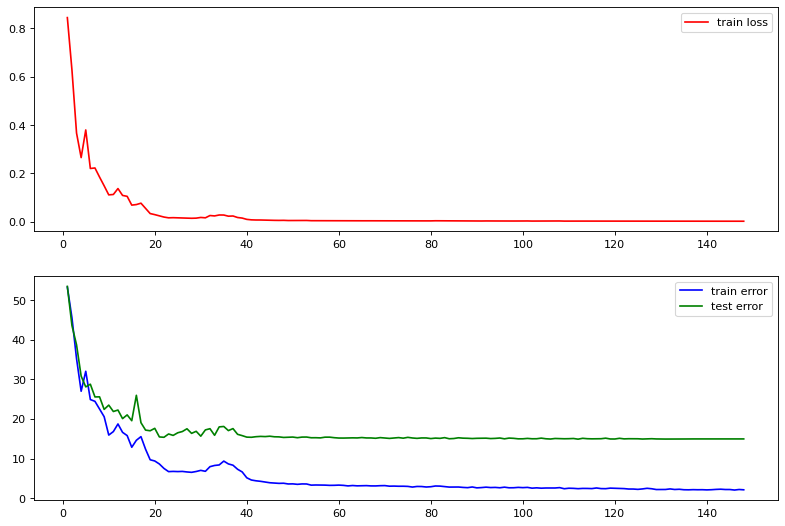

0.01

In [10]:
model.plotloss()
model.lr
# for i in temp_test_error:
#     print(i)
# print()
# print('average of error which larger than 25:  ', sum(map(lambda t: ((t[0][0]-t[1][0])**2+(t[0][1]-t[1][1])**2)**0.5, temp_test_error))/len(temp_test_error))
# print('average of error which less than 25:  ', (29.241338*182 - sum(map(lambda t: ((t[0][0]-t[1][0])**2+(t[0][1]-t[1][1])**2)**0.5, temp_test_error))) / (182-len(temp_test_error)))

In [11]:
model.predict([9.695435, 35.49347, -36.782837, {
        "04:40:a9:a1:9a:61": -50,
        "04:40:a9:a1:87:61": -56,
        "04:40:a9:a1:95:01": -65,
        "04:40:a9:a1:7d:e1": -72,
    }, {}])

FileNotFoundError: [Errno 2] No such file or directory: '../data\\site2\\F4\\floor_image.png'

<Figure size 640x480 with 0 Axes>

<Figure size 960x960 with 0 Axes>